# Introduction

Interpolation is a long standing problem and most commercial solutions are based on Fourier or Radon transforms. Here we want 
to investigate the feasibility of a an alternative, neural network based approach.
Seismic interpolation is usually carried out in 4 or 5 dimensions and often incorporates regularization. In this POC we use a 
convolutional Autoencoder applied to 2D-seismic data. 
- Two lines,one for training the other for test

Principle: We feed the autoencder with data and match it to the output. howver, to be able to do interpolation we need to 
    remove data from the seismic input while we leave the target unaltered. Typically missing data in seismic procesing is 
    between 1 and 10 traces wide and therefore we cut out vertical stripes from out data that is up to 10 pixels/traces wide.
    Since, the target is unaltered, the model will have to opportunity to learn to tie the gappy data to the complete data. 
    Having this generalised knowledged trained the VAE hopefully will be able to interpolated datra it has never seen before.
    

# Code definition

Here we define two classes which will make our life easier when training the VAE. 
The input/source and the output/target data for the VAE are not identical in this experiments since, as explained above, the 
input data contains missing stripes, or traces in seismic jargon, that the VAE should fill in. The class Batch is a container class 
that holds botht eh source and the target.
Utility is a class containg various mathods to generate the batches. *get_source_and_target* takes the seismic data, stored in a 800x200 numpy array and cuts out a random square of 28x28 elements. This element is normalised such that the values are in the inteval [0,1] and 
the zero in the original array equals 1/2. Additionally a copy of the normalised 28x28 square is generated and a, at a probaboilty of 50% a chunck/verticalstripe up to 11 pixels wide is replaced with zeros. The latter square then is used to feed the VAE while the square containing all the data is used as target, such that the Autoencoder can learn to interpolate the missing data


In [176]:
import numpy, math, random
from scipy.signal import resample
import torch

class Batch():
    
  def __init__(self, source, target):
    self.target = target
    self.source = source
    
  def get_source(self):
    return self.source
  
  def get_target(self):
    return self.target

class Utility:
  
  def __init__(self):
    self.seismic_1 = numpy.load('./data/seismic/seismic_1.npy')
    self.seismic_1 = resample(self.seismic_1, 800)
    self.seismic_2 = numpy.load('./data/seismic/seismic_2.npy')
    self.seismic_2 = resample(self.seismic_2, 800)
    self.batch_length = 1024
    
  def _f(self, x):
    return -numpy.cos(x*math.pi)/2.+0.5
  
  def _g(self, y):
    return numpy.arccos(1-2*y)/math.pi
  
  def power_f(self, __f, _exp):
    def _f(x):
        for i in range(_exp):
            x = __f(x)
        return x
    return _f
  
  def _normalize(self, im):
    fac = (2*max(numpy.nanmax(im), -numpy.nanmin(im)))
    im = im / fac + 0.5
    return im, fac, -0.5
  
  def _denormalize(self, im, scale, offset = -0.5):
    im = fac * ( im + offset )
    return im
  
  def _make_batch(self, training = True):
    sources_and_targets = [self._get_source_and_target(
        self.seismic_2 if training else self.seismic_1
      ) for i in range(self.batch_length)]
    source = [elem[0] for elem in sources_and_targets]
    target =  [elem[1] for elem in sources_and_targets]
    return Batch(torch.stack(torch.FloatTensor(source)).unsqueeze(1),
         torch.stack(torch.FloatTensor(target)).unsqueeze(1)
          )
  
  def _get_source_and_target(self, im, low = True):
    #if low:
    a_=random.randint(0,im.shape[0]-28)
    b_=random.randint(0,im.shape[1]-28)
    p_ = im[a_:a_+28, b_:b_+28].copy()
    p_,_,_ = self._normalize(p_)
    if random.randint(0,1)==1:
      p_ = numpy.flip(p_, axis = 1)
    p_ = self.power_f(self._f, 2)(p_)
    t_ = numpy.clip(p_, 0, 1)
    s_ = t_.copy()
    a_=random.randint(9,19)
    b_=random.randint(11,21)
    s_[:,a_:b_] = 0
    return s_, t_
  
util = Utility()
batch = util._make_batch()

## The seismic data

Here we plot the seismic data that is used for training and testing. Both are 800 pixels long and between 200 and 229 pixels wide. Both
samples are different lines at the opposite sides a one and the same seismic survey. 

<IPython.core.display.Javascript object>


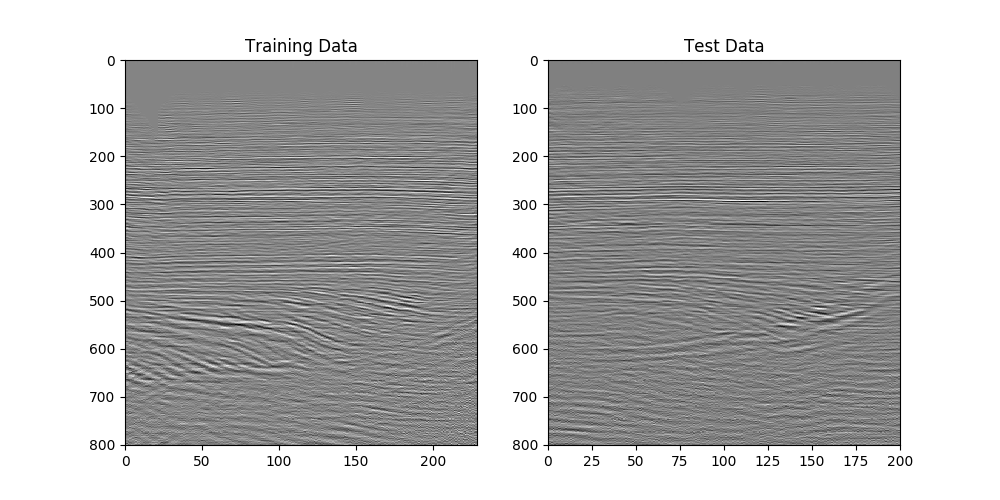

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook
import random

plt.figure(figsize=(10,5))  

plt.subplot(121)
plt.gca().invert_yaxis()
plt.title("Training Data")
plt.pcolormesh(util.seismic_2, cmap="gray")

plt.subplot(122)
plt.gca().invert_yaxis()
plt.title("Test Data")
plt.pcolormesh(util.seismic_1, cmap="gray")

## A sample batch

As explained above the VAE is fed with squares of 28x28 pixels. The batches are generated from these tiles

<IPython.core.display.Javascript object>


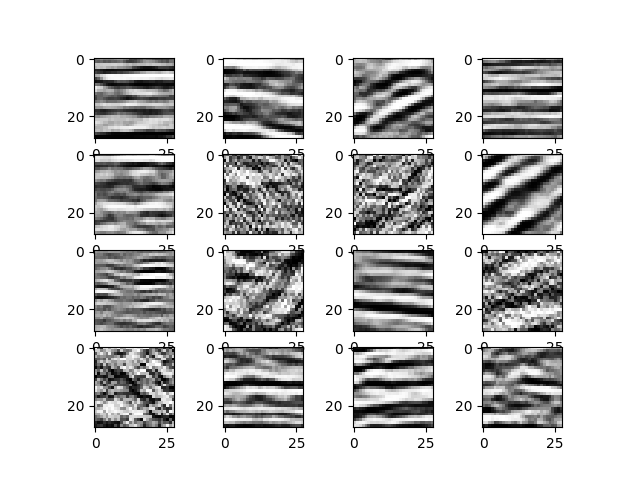

In [33]:
import matplotlib.pyplot as plt, itertools
%matplotlib notebook

_range = range(4)

for idx, (i, j) in enumerate([(i,j) for i in _range for j in _range]):
    plt.subplot(4,4,idx+1)
    plt.imshow(batch.get_target()[idx][0], cmap="gray")
    
#plt.pcolormesh(im, cmap="gray")#

The same tiles as before with chunks cut out for interpolation

<IPython.core.display.Javascript object>


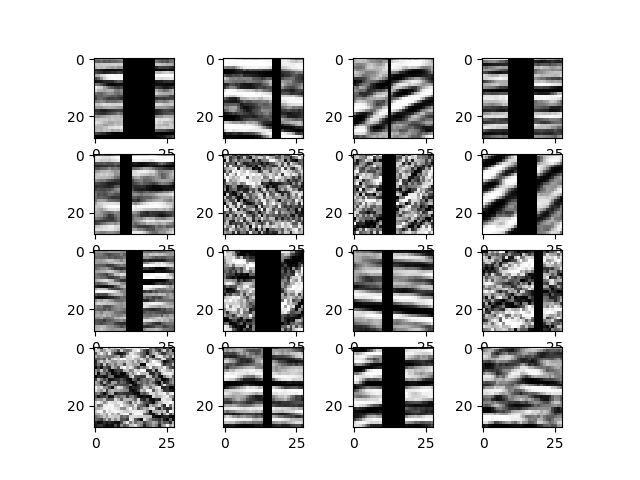

In [34]:
import matplotlib.pyplot as plt, itertools
%matplotlib notebook

_range = range(4)

for idx, (i, j) in enumerate([(i,j) for i in _range for j in _range]):
    plt.subplot(4,4,idx+1)
    plt.imshow(batch.get_source()[idx][0], cmap="gray")
    

## Train the model

In [ ]:
from torch.autograd import Variable
import codes.VAE as VAE
import codes.ConvolutionCoders.Encoder as Encoder
from importlib import reload
reload(Encoder)

class VAE_Wrapper:

  def __init__(self, vae, util, training_batches, test_batches):
    self.vae = vae
    self.util = util
    self.training_batches = training_batches
    self.test_batches = test_batches
    self.vae.cuda()
    self.train_op = optim.Adam(self.vae.parameters(), lr=0.0005)
    
  def train_batch(self):
    model = self.vae
    train_op = self.train_op
    loss_ = []
    n = []
    for _, data in enumerate(self.training_batches):
      # data = Variable(data.view(-1,784))
      source = Variable(data.get_source())
      source = source.cuda()
      target = Variable(data.get_target()).cuda()
      
      train_op.zero_grad()
      dec = model(source)
      target = target
      dec = dec
      loss = model.loss(target, dec, model.mu, model.log_std)
      loss_.append(loss.data[0])
      n.append(len(source))
      loss.backward()
      train_op.step() 
      
    loss_train = numpy.sum(loss_) / numpy.sum(n)
    loss_ = []
    n = []    
    for _, data in enumerate(self.test_batches):
      # data = Variable(data.view(-1,784))
      source = Variable(data.get_source())
      source = source.cuda()
      target = Variable(data.get_target()).cuda()
      dec = model(target)
      target = target
      dec = dec
      loss = model.loss(target, dec, model.mu, model.log_std)
      loss_.append(loss.data[0])
      n.append(len(source))
      
    loss_test = numpy.sum(loss_) / numpy.sum(n)
    
    return loss_train, loss_test
 
  def add_new_batch(self):
    if not p:
      return training_batches 
    if False:
      return training_batches 
    training = []
    if (len(training_batches) >= 10):
      training_batches.pop(0)
  
    training_batches.append(self.util._make_batch())
    return training_batches

import math, torch
training_batches = [batch]
test_batches = []

for i in range(10):
  test_batches.append(util._make_batch(training = False))  

wrapper = VAE_Wrapper(VAE.VariationalAutoEncoder(18, 0, convolutional = True),
       util, training_batches, test_batches)
for epoch in range(10000):
  loss_mean, loss_test = wrapper.train_batch()
 
  if epoch%20==0:
    print("{}: ".format(epoch), loss_mean, loss_test)

In [43]:
vae = VAE.VariationalAutoEncoder(18, 0, convolutional = True)
vae.load_state_dict(torch.load("./data/saved_models/vae_SI_n18.pyt", map_location={'cuda:0': 'cpu'}))

## Display results

<IPython.core.display.Javascript object>


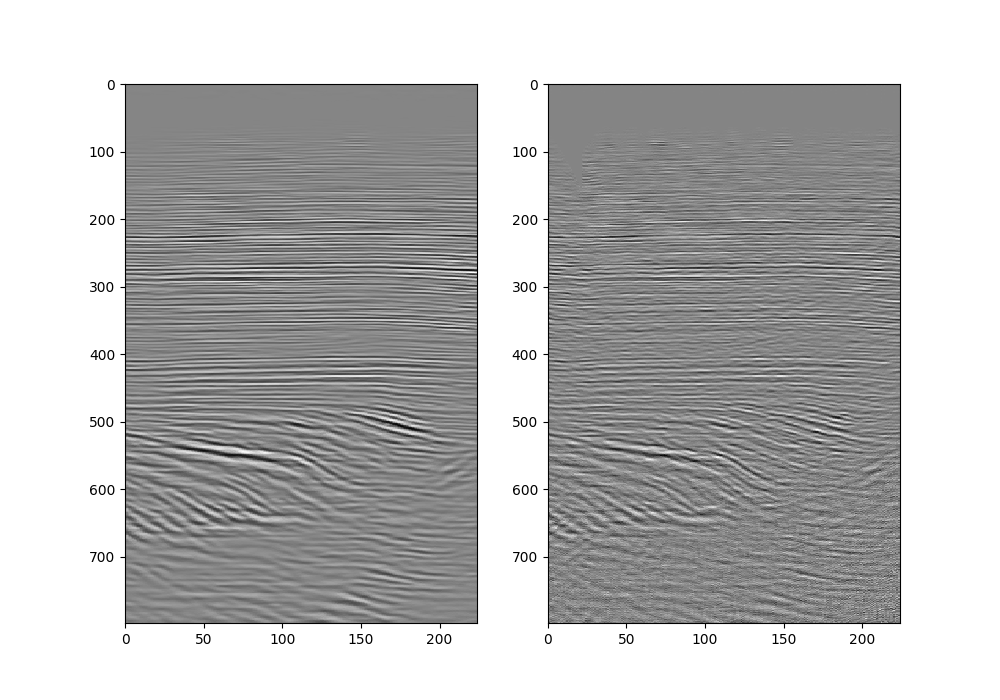

In [97]:
from scipy.signal import triang
win = numpy.ones((28,28))
tx, ty = numpy.meshgrid(triang(28), triang(28))
win *= tx
win *= ty

im_ =  util.seismic_2

import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
arr = numpy.zeros(im_.shape)
%matplotlib notebook
plt.gca().invert_yaxis()
for i in numpy.arange(0,800-28,14):
    for j in numpy.arange(0,229-28,14):
        p_ = im_[i:i+28,j:j+28].copy()
        p_, fac, _ = util._normalize(p_)
        p_ = util.power_f(util._f,2)(p_)
        o_ = vae(Variable(torch.FloatTensor(p_)).unsqueeze(0).unsqueeze(0))[0,0].data.numpy()
        o_ = util.power_f(util._g,2)(o_)
        o_ = util._denormalize(o_, fac)

        arr[i:i+28,j:j+28] += \
          o_*win
            
        if j==0: arr[i:i+28,0:14] +=  o_[:,0:14]*win[:,14:28]     
        if i==0: arr[0:14,j:j+28] += o_[0:14,:]*win[14:28,:]
        if i==770: arr[i+14:i+28,j:j+28] += o_[14:28,:]*win[0:14,:]
        if j==196: arr[i:i+28,j+14:j+28] +=  o_[:,14:28]*win[:,0:14]   
        if (i==0)&(j==0): arr[0:14, 0:14] += o_[0:14,0:14]*win[14:28,14:28]
        if (i==770)&(j==0): arr[i+14:i+28,0:14] += o_[14:28,0:14]*win[0:14,14:28]
        if (i==0)&(j==196): arr[0:14, j+14:j+28] += o_[0:14,14:28]*win[14:28,0:14]
        if (i==770)&(j==196): arr[i+14:i+28, j+14:j+28] += o_[14:28,14:28]*win[0:14,0:14]    
plt.subplot(121)
plt.gca().invert_yaxis()
plt.pcolormesh(arr[0:798,0:224], cmap="gray")
plt.subplot(122)
plt.gca().invert_yaxis()
plt.pcolormesh(im_[0:798,0:224], cmap="gray")

<IPython.core.display.Javascript object>


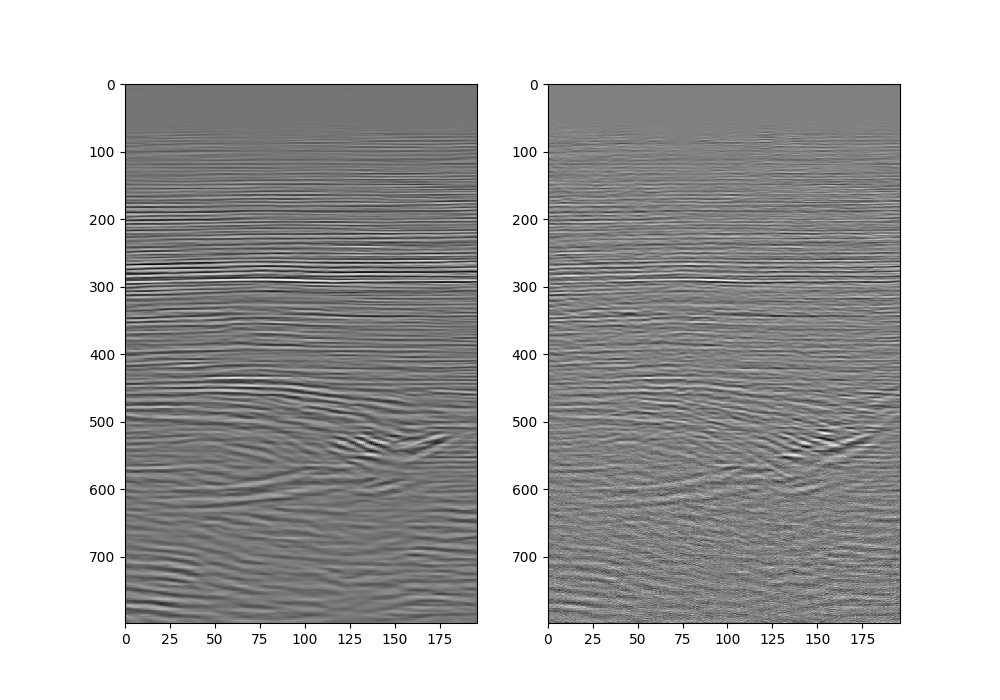

In [108]:
from scipy.signal import triang
win = numpy.ones((28,28))
tx, ty = numpy.meshgrid(triang(28), triang(28))
win *= tx
win *= ty

im_ =  util.seismic_1
#im_[:,140-4:140+5]=0

import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
arr = numpy.zeros(im_.shape)
#%matplotlib notebook
plt.gca().invert_yaxis()
for i in numpy.arange(0,800-28,14):
    for j in numpy.arange(0,200-28,14):
        p_ = im_[i:i+28,j:j+28].copy()
        p_, fac, _ = util._normalize(p_)
        p_ = util.power_f(util._f,2)(p_)
        o_ = vae(Variable(torch.FloatTensor(p_)).unsqueeze(0).unsqueeze(0))[0,0].data.numpy()
        o_ = util.power_f(util._g,2)(o_)
        o_ = util._denormalize(o_, fac)

        arr[i:i+28,j:j+28] += \
          o_*win
            
        if j==0: arr[i:i+28,0:14] +=  o_[:,0:14]*win[:,14:28]     
        if i==0: arr[0:14,j:j+28] += o_[0:14,:]*win[14:28,:]
        if i==770: arr[i+14:i+28,j:j+28] += o_[14:28,:]*win[0:14,:]
        if j==168: arr[i:i+28,j+14:j+28] +=  o_[:,14:28]*win[:,0:14]   
        if (i==0)&(j==0): arr[0:14, 0:14] += o_[0:14,0:14]*win[14:28,14:28]
        if (i==770)&(j==0): arr[i+14:i+28,0:14] += o_[14:28,0:14]*win[0:14,14:28]
        if (i==0)&(j==168): arr[0:14, j+14:j+28] += o_[0:14,14:28]*win[14:28,0:14]
        if (i==770)&(j==168): arr[i+14:i+28, j+14:j+28] += o_[14:28,14:28]*win[0:14,0:14]    
        
plt.subplot(121)
plt.gca().invert_yaxis()
plt.pcolormesh(arr[0:798,0:196], cmap="gray")
plt.subplot(122)
plt.gca().invert_yaxis()
plt.pcolormesh(im_[0:798,0:196], cmap="gray")

<IPython.core.display.Javascript object>


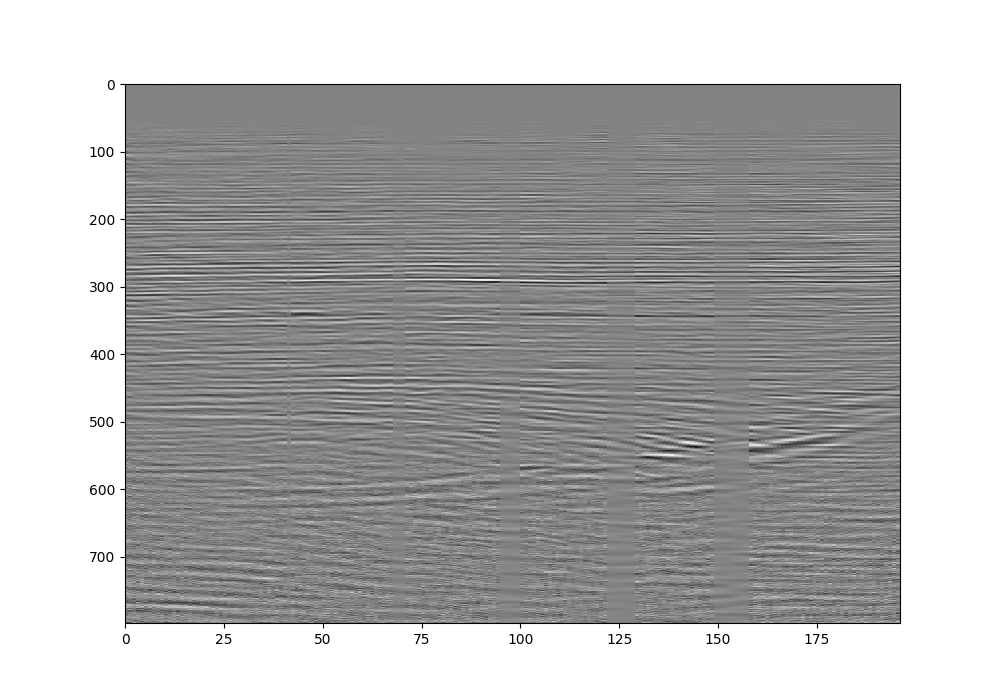

In [172]:
im_ =  util.seismic_1.copy()
#im_[:,140-4:140+5]=0

for i in range(5):
    im_[:,42+i*28-i-1:42+i*28+i]=numpy.nan

plt.figure(figsize=(10,7))
arr = numpy.zeros(im_.shape)
#%matplotlib notebook
for i in numpy.arange(0,800-28,14):
    for j in numpy.arange(0,200-28,14):
        p_ = im_[i:i+28,j:j+28].copy()
        p_, fac, _ = util._normalize(p_)
        p_ = util.power_f(util._f,2)(p_)
        p_ = numpy.nan_to_num(p_)
        o_ = vae(Variable(torch.FloatTensor(p_)).unsqueeze(0).unsqueeze(0))[0,0].data.numpy()
        o_ = util.power_f(util._g,2)(o_)
        o_ = util._denormalize(o_, fac)

        arr[i:i+28,j:j+28] += \
          o_*win
            
        if j==0: arr[i:i+28,0:14] +=  o_[:,0:14]*win[:,14:28]     
        if i==0: arr[0:14,j:j+28] += o_[0:14,:]*win[14:28,:]
        if i==770: arr[i+14:i+28,j:j+28] += o_[14:28,:]*win[0:14,:]
        if j==168: arr[i:i+28,j+14:j+28] +=  o_[:,14:28]*win[:,0:14]   
        if (i==0)&(j==0): arr[0:14, 0:14] += o_[0:14,0:14]*win[14:28,14:28]
        if (i==770)&(j==0): arr[i+14:i+28,0:14] += o_[14:28,0:14]*win[0:14,14:28]
        if (i==0)&(j==168): arr[0:14, j+14:j+28] += o_[0:14,14:28]*win[14:28,0:14]
        if (i==770)&(j==168): arr[i+14:i+28, j+14:j+28] += o_[14:28,14:28]*win[0:14,0:14]    

arr[numpy.invert(numpy.isnan(im_))]  = im_[numpy.invert(numpy.isnan(im_))]
plt.gca().invert_yaxis()
plt.pcolormesh(arr[0:798,0:196], cmap="gray")

<IPython.core.display.Javascript object>


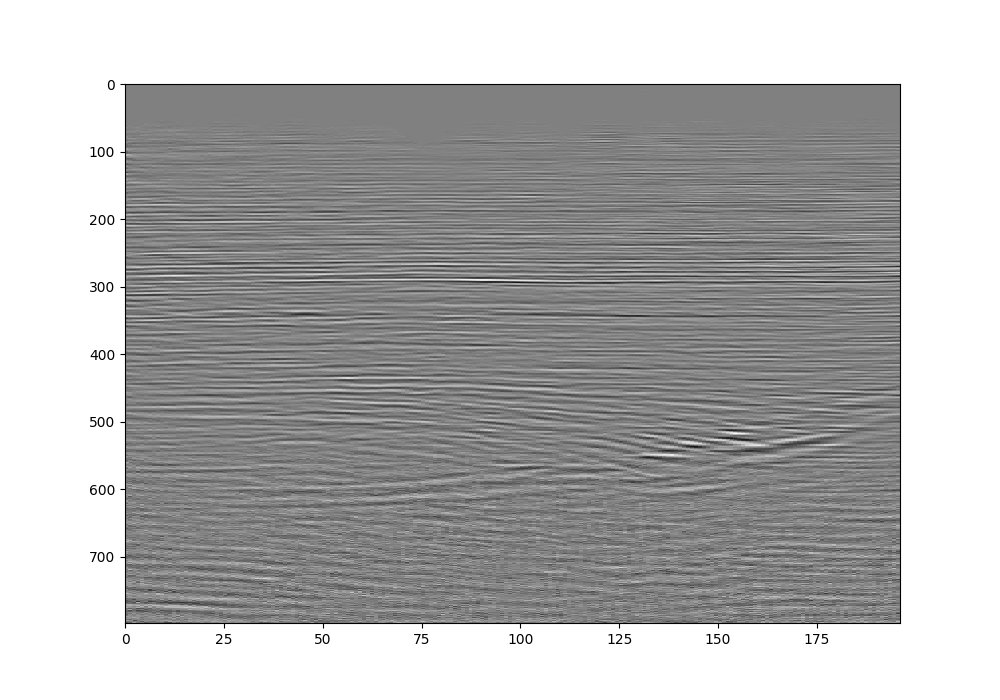

In [171]:
im_ =  util.seismic_1.copy()
#im_[:,140-4:140+5]=0


plt.figure(figsize=(10,7))

plt.gca().invert_yaxis()
plt.pcolormesh(im_[0:798,0:196], cmap="gray")